<a href="https://colab.research.google.com/github/shivesh-ranjan/Sentimental-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt

In [4]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1ZTSYE/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1ZTSYE/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1ZTSYE/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
# shuffling the data
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
# avoiding any i/o bottleneck
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"A team of archaeologists uncover a real treasure \xc2\x96 the Crown of the Queen of Sheeba. From Egypt, the crown is to be transferred via steamship to San Francisco. But it won't be an easy journey. There are plenty of would-be thieves who would love to get their hands on the priceless jewels contained in the crown. Fortunately for all involved, Mr. Moto is on hand to guard the crown on its journey. However, that doesn't mean someone won't try to get their hands on the treasure.<br /><br />After the disappointment of Mr. Moto's Gamble, I went into Mr. Moto Takes a Vacation hoping for the best, but, admittedly, fearing the worst. But within the first 10 seconds of the film, I knew I would find it more enjoyable. I'm a sucker for a 1930s style mystery that features anything to do with archaeological digs in Egypt. And seeing Moto disguised as a German archaeologist (Imagine that, Peter Lorre playing a German?), the beginning scenes really drew me in. While the movie may have 

In [11]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [13]:
#lstm with 1 layer model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Using masking to handle the variable sequence lengths
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 111s 248ms/step - loss: 0.6553 - accuracy: 0.5598 - val_loss: 0.5371 - val_accuracy: 0.7135
Epoch 2/10
391/391 [==============================] - 92s 236ms/step - loss: 0.4208 - accuracy: 0.8023 - val_loss: 0.3788 - val_accuracy: 0.8401
Epoch 3/10
391/391 [==============================] - 90s 230ms/step - loss: 0.3423 - accuracy: 0.8492 - val_loss: 0.3539 - val_accuracy: 0.8490
Epoch 4/10
391/391 [==============================] - 89s 229ms/step - loss: 0.3227 - accuracy: 0.8599 - val_loss: 0.3395 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 90s 231ms/step - loss: 0.3137 - accuracy: 0.8641 - val_loss: 0.3345 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 90s 229ms/step - loss: 0.3084 - accuracy: 0.8663 - val_loss: 0.3318 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 91s 232ms/step - loss: 0.3048 - accuracy: 0.8679 - val_loss: 0.3304 - val_a

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 48s 122ms/step - loss: 0.3244 - accuracy: 0.8648
Test Loss: 0.32436975836753845
Test Accuracy: 0.8648399710655212


(0.0, 0.6731827512383461)

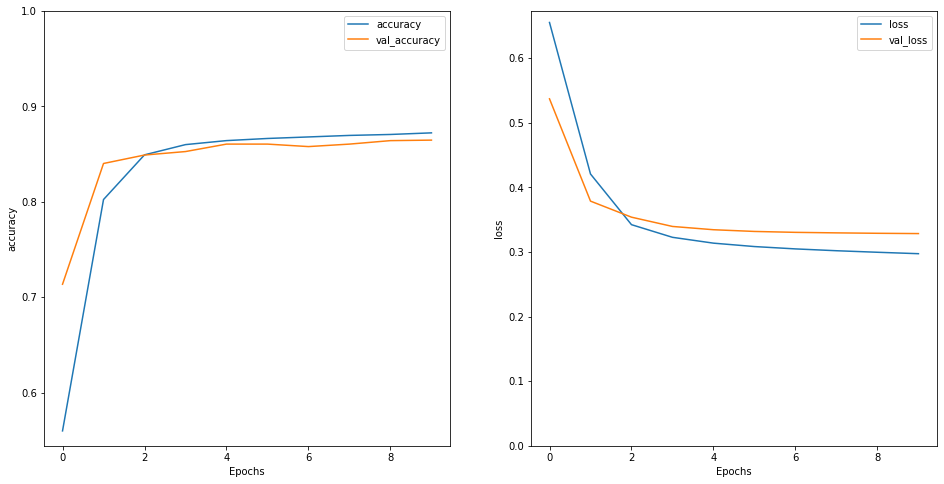

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [19]:
# Stacking two LSTM layers 
#return sequences is true which means it will return prediction or y hat at each time step of a given sequence
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 193s 450ms/step - loss: 0.6529 - accuracy: 0.5384 - val_loss: 0.4978 - val_accuracy: 0.7266
Epoch 2/10
391/391 [==============================] - 172s 438ms/step - loss: 0.4098 - accuracy: 0.8102 - val_loss: 0.3732 - val_accuracy: 0.8339
Epoch 3/10
391/391 [==============================] - 166s 425ms/step - loss: 0.3502 - accuracy: 0.8432 - val_loss: 0.3883 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 170s 434ms/step - loss: 0.3323 - accuracy: 0.8571 - val_loss: 0.3438 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 168s 430ms/step - loss: 0.3198 - accuracy: 0.8627 - val_loss: 0.3376 - val_accuracy: 0.8625
Epoch 6/10
391/391 [==============================] - 167s 428ms/step - loss: 0.3139 - accuracy: 0.8663 - val_loss: 0.3377 - val_accuracy: 0.8625
Epoch 7/10
391/391 [==============================] - 171s 436ms/step - loss: 0.3087 - accuracy: 0.8657 - val_loss: 0.3371 -

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 84s 214ms/step - loss: 0.3288 - accuracy: 0.8630
Test Loss: 0.32878202199935913
Test Accuracy: 0.8629599809646606


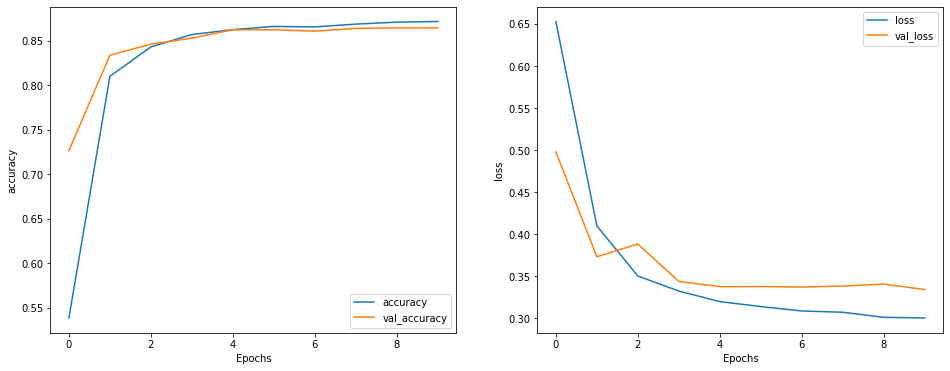

In [23]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')